# **Challenge 2, due 22/11/21**

Students: Alice Schiavone, Davide D'Ascenzo

# Env Set up

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install -q findspark
!pip show pyspark
!pip install memory_profiler
%load_ext memory_profiler

     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 198 kB 46.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=66a78851cc750a8ebd2890522c4a9d8b9988a6047d7c665930536804138bb3df
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Name: pyspark
Version: 3.2.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: py4j
Required-by: 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=dae218dd4bcb9bab4ac65a2e873c69ccd028869a4e6de69058557f4299311964
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"

import pyspark
sc = pyspark.SparkContext("local[*]").getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
import findspark
findspark.init()

# Text Choice and Pre-processing 📜
I will compute the similarities between [Shakespeare works](http://shakespeare.mit.edu/). 





In [4]:
!wget https://github.com/aliswh/architectures-for-big-data/raw/main/data/shakespeare.zip
!mkdir /content/shakespeare
!unzip /content/shakespeare.zip -d /content/shakespeare

--2021-11-20 12:50:46--  https://github.com/aliswh/architectures-for-big-data/raw/main/data/shakespeare.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/shakespeare.zip [following]
--2021-11-20 12:50:46--  https://raw.githubusercontent.com/aliswh/architectures-for-big-data/main/data/shakespeare.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2137820 (2.0M) [application/zip]
Saving to: ‘shakespeare.zip’

shakespeare.zip     100%[===================>]   2.04M  --.-KB/s    in 0.06s   

2021-11-20 12:50:46 (32.0 MB/s) - ‘shakespeare.zip’ saved [2137

In [5]:
import os
data_path = '/content/shakespeare/'
f"Total number of texts: {len(os.listdir(data_path))}"

'Total number of texts: 37'

In [6]:
import re

stem = '[0-9]*[!@#$%^&*_+=\-;:,.—<>?\'\/\\\ "()\[\]]+'

for text in os.listdir(data_path):
  text_name = re.sub(stem, '', text)
  file_path = data_path + text_name
  os.rename(data_path + text, file_path) 

rdd_texts = sc.wholeTextFiles(data_path) # create RDD

def rename_texts(x):
  return re.sub('file:'+data_path, '', x)
def clean_text(x):
  return re.sub(stem, ' ', x).lower()

rdd_texts = rdd_texts.map(lambda x: (rename_texts(x[0]), clean_text(x[1]) ) )\
                     .map(lambda x: (x[0], x[1].split()))
rdd_texts.count()

37

# Solution

## Histogram ⭐

In [7]:
rdd_occurences = rdd_texts.flatMap(lambda x: [((x[0],y),1) for y in x[1]])
rdd_occurences.take(3)

[(('TimonofAthenstxt', 'shakespeare'), 1),
 (('TimonofAthenstxt', 'timon'), 1),
 (('TimonofAthenstxt', 'of'), 1)]

In [8]:
rdd_occurences = rdd_texts.flatMapValues(lambda x: x).map(lambda x: (x,1)) # alternative
rdd_occurences.take(3)

[(('TimonofAthenstxt', 'shakespeare'), 1),
 (('TimonofAthenstxt', 'timon'), 1),
 (('TimonofAthenstxt', 'of'), 1)]

In [9]:
rdd_hist = rdd_occurences.reduceByKey(lambda x,y: x+y)
rdd_hist.take(3)

[(('TimonofAthenstxt', 'shakespeare'), 2),
 (('TimonofAthenstxt', 'of'), 329),
 (('TimonofAthenstxt', 'online'), 1)]

## Visual histogram

In [10]:
N = 5
print(rdd_hist.map(lambda x : x[1]).histogram(N)) # pyspark implementation

([1.0, 231.2, 461.4, 691.5999999999999, 921.8, 1152], [128727, 476, 131, 49, 12])


In [11]:
MAX = rdd_hist.map(lambda x : x[1]).max() + 1 
bins = {((i-1)*MAX//N, i*MAX//N):0 for i in range(1,N+1)} # Create N even intervals

sorted(rdd_hist.map(lambda x: [b for b in bins if x[1] in range (b[0],b[1]) ]).map(lambda x: (x[0],1)).reduceByKey(lambda x,y: x+y).collect())

[((0, 230), 128718),
 ((230, 461), 484),
 ((461, 691), 131),
 ((691, 922), 50),
 ((922, 1153), 12)]

Most frequent word in a text: (('HamletPrinceofDenmarktxt', 'the'), 1152)


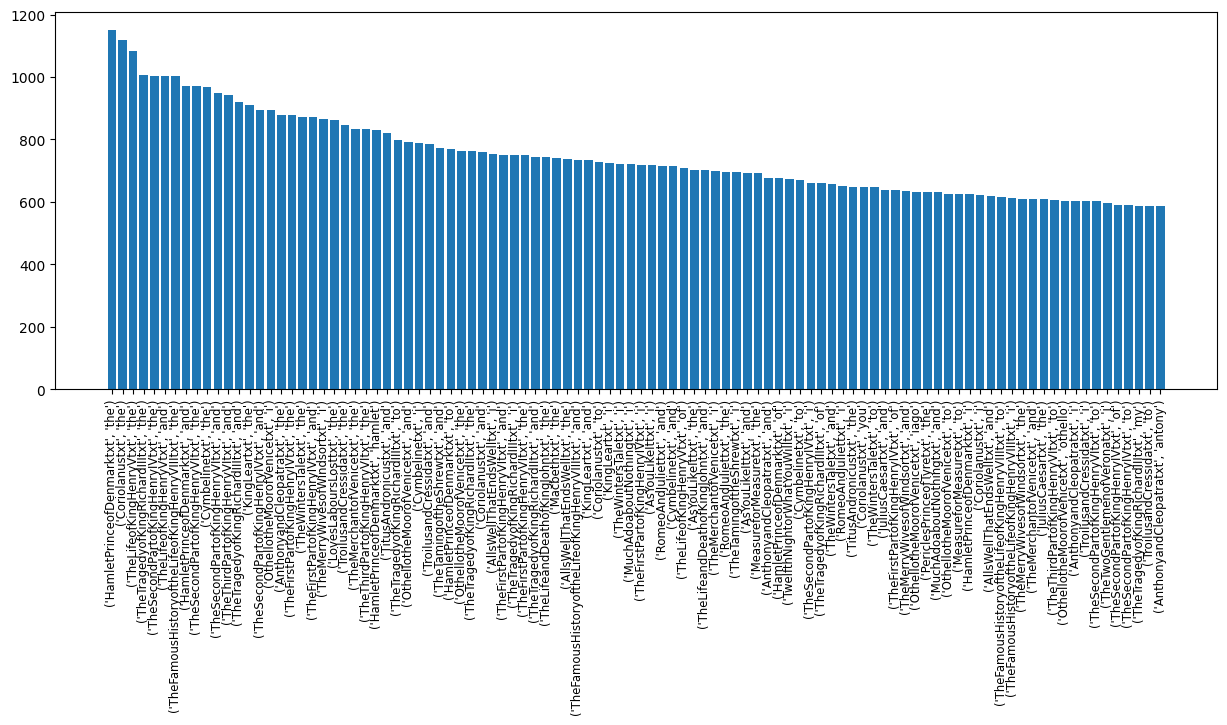

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for_histogram_rdd = rdd_hist.sortBy(lambda x: x[1], ascending=False)
print(f"Most frequent word in a text: {for_histogram_rdd.first()}") # just to check if the plot is correct

data = for_histogram_rdd.map(lambda x: x[0]).take(100)
labels = for_histogram_rdd.map(lambda x: x[1]).take(100)

figure(figsize=(15, 5), dpi=100)
plt.bar(range(len(labels)), labels)
plt.xticks(range(len(data)), data, rotation='vertical', size='small')
plt.show()

## More pre-processing: computing TF.IDF


Term Frequency
> Occurence of term w.r.t. the most frequent term in the document

In [13]:
max_rdd = rdd_hist.map(lambda x: (x[0][0], x[1] ) ).reduceByKey(lambda x,y: max(x,y))
max_rdd.take(10)

[('TimonofAthenstxt', 548),
 ('TroilusandCressidatxt', 847),
 ('TheThirdPartofKingHenryVItxt', 942),
 ('Coriolanustxt', 1118),
 ('MuchAdoaboutNothingtxt', 721),
 ('AnthonyandCleopatratxt', 879),
 ('HamletPrinceofDenmarktxt', 1152),
 ('TheWintersTaletxt', 873),
 ('TheSecondPartofKingHenryIVtxt', 1004),
 ('TheLifeofKingHenryVtxt', 1083)]

In [14]:
tf_rdd = rdd_hist.map(lambda x: (x[0][0], (x[0][1], x[1]))).join(max_rdd).mapValues(lambda x:  (x[0][0], x[0][1] / x[1] ))
tf_rdd.take(10)

[('TroilusandCressidatxt', ('shakespeare', 0.0023612750885478157)),
 ('TroilusandCressidatxt', ('troilus', 0.44391971664698937)),
 ('TroilusandCressidatxt', ('cressida', 0.3860684769775679)),
 ('TroilusandCressidatxt', ('online', 0.0011806375442739079)),
 ('TroilusandCressidatxt', ('library', 0.0011806375442739079)),
 ('TroilusandCressidatxt', ('of', 0.5974025974025974)),
 ('TroilusandCressidatxt', ('oll', 0.0011806375442739079)),
 ('TroilusandCressidatxt', ('libertyfund', 0.0011806375442739079)),
 ('TroilusandCressidatxt', ('org', 0.0011806375442739079)),
 ('TroilusandCressidatxt', ('version', 0.0011806375442739079))]

Inverse Document Frequency
> For each term, divide the total number of documents by the number of documents that contain that term

In [15]:
from math import log 
N_docs = rdd_hist.map(lambda x: (x[0][0])).distinct().count()

idf_rdd = rdd_hist.map(lambda x: (x[0][1], 1)).reduceByKey(lambda x,y: x+y).mapValues(lambda x: log( N_docs / x ))
idf_rdd.take(10)

[('shakespeare', 0.0),
 ('of', 0.0),
 ('online', 0.0),
 ('library', 0.0),
 ('oll', 0.0),
 ('libertyfund', 0.0),
 ('org', 0.0),
 ('version', 0.0),
 ('mike', 0.0),
 ('scott', 0.0)]

In [16]:
tf_idf_rdd = tf_rdd.map(lambda x: (x[1][0], (x[0], x[1][1]) ) ).join(idf_rdd).map(lambda x: (x[0], (x[1][0][0], x[1][0][1] * x[1][1]) ) )
tf_idf_rdd.takeOrdered(10)

[('a', ('AMidsummerNightsDreamtxt', 0.0)),
 ('a', ('AllsWellThatEndsWelltxt', 0.0)),
 ('a', ('AnthonyandCleopatratxt', 0.0)),
 ('a', ('AsYouLikeIttxt', 0.0)),
 ('a', ('Coriolanustxt', 0.0)),
 ('a', ('Cymbelinetxt', 0.0)),
 ('a', ('HamletPrinceofDenmarktxt', 0.0)),
 ('a', ('JuliusCaesartxt', 0.0)),
 ('a', ('KingLeartxt', 0.0)),
 ('a', ('LovesLaboursLosttxt', 0.0))]

In [17]:
tf_idf_rdd = tf_idf_rdd.filter(lambda x: x[1][1] != 0)
tf_idf_rdd.takeOrdered(10)

[('aaron', ('TitusAndronicustxt', 0.6729238010165242)),
 ('abaissez', ('TheLifeofKingHenryVtxt', 0.003334180898101777)),
 ('abandon', ('AsYouLikeIttxt', 0.00928874624038444)),
 ('abandon', ('OthellotheMoorofVenicetxt', 0.001864510373559811)),
 ('abandon', ('TheTamingoftheShrewtxt', 0.0021595431434356825)),
 ('abandon', ('TheThirdPartofKingHenryVItxt', 0.0017675241651686955)),
 ('abandon', ('TimonofAthenstxt', 0.003038335335016261)),
 ('abandon', ('TroilusandCressidatxt', 0.0019657706772006033)),
 ('abandon', ('TwelfthNightorWhatYouWilltxt', 0.0024776901243882604)),
 ('abandoned', ('AllsWellThatEndsWelltxt', 0.0038800142713886687))]

In [18]:
tf_idf_rdd.map(lambda x : (x[0], x[1][1])).takeOrdered(10, key=lambda x: -x[1])

[('syr', 2.923468610637809),
 ('timon', 2.917770732084279),
 ('antipholus', 2.851105526216081),
 ('dromio', 2.742560899583489),
 ('hamlet', 2.598481727067762),
 ('iago', 2.5555432483663494),
 ('macbeth', 2.542281395253569),
 ('othello', 2.442322977869106),
 ('rosalind', 2.3972063129967234),
 ('romeo', 2.3753384592952926)]

## Cosine similarity ⭐

In [19]:
term_key_rdd = rdd_hist.map(lambda x: (x[0][1], (x[0][0], x[1])))
term_key_rdd.take(3)

[('shakespeare', ('TimonofAthenstxt', 2)),
 ('of', ('TimonofAthenstxt', 329)),
 ('online', ('TimonofAthenstxt', 1))]

In [20]:
inner_join_rdd = term_key_rdd.join(term_key_rdd)
inner_join_rdd.take(10)

[('of', (('TimonofAthenstxt', 329), ('TimonofAthenstxt', 329))),
 ('of', (('TimonofAthenstxt', 329), ('TroilusandCressidatxt', 506))),
 ('of', (('TimonofAthenstxt', 329), ('TheThirdPartofKingHenryVItxt', 425))),
 ('of', (('TimonofAthenstxt', 329), ('Coriolanustxt', 478))),
 ('of', (('TimonofAthenstxt', 329), ('MuchAdoaboutNothingtxt', 364))),
 ('of', (('TimonofAthenstxt', 329), ('AnthonyandCleopatratxt', 452))),
 ('of', (('TimonofAthenstxt', 329), ('HamletPrinceofDenmarktxt', 675))),
 ('of', (('TimonofAthenstxt', 329), ('TheWintersTaletxt', 479))),
 ('of', (('TimonofAthenstxt', 329), ('TheSecondPartofKingHenryIVtxt', 590))),
 ('of', (('TimonofAthenstxt', 329), ('TheLifeofKingHenryVtxt', 709)))]

In [21]:
def make_pairs(x):
    return ((x[1][0][0],x[1][1][0]),(x[1][0][1],x[1][1][1]))

doc_pairs_rdd = inner_join_rdd.filter(lambda x: x[1][0][0] != x[1][1][0]).map(lambda x: make_pairs(x))
doc_pairs_rdd.take(10)

[(('TimonofAthenstxt', 'TroilusandCressidatxt'), (329, 506)),
 (('TimonofAthenstxt', 'TheThirdPartofKingHenryVItxt'), (329, 425)),
 (('TimonofAthenstxt', 'Coriolanustxt'), (329, 478)),
 (('TimonofAthenstxt', 'MuchAdoaboutNothingtxt'), (329, 364)),
 (('TimonofAthenstxt', 'AnthonyandCleopatratxt'), (329, 452)),
 (('TimonofAthenstxt', 'HamletPrinceofDenmarktxt'), (329, 675)),
 (('TimonofAthenstxt', 'TheWintersTaletxt'), (329, 479)),
 (('TimonofAthenstxt', 'TheSecondPartofKingHenryIVtxt'), (329, 590)),
 (('TimonofAthenstxt', 'TheLifeofKingHenryVtxt'), (329, 709)),
 (('TimonofAthenstxt', 'TheFirstPartofKingHenryIVtxt'), (329, 637))]

In [22]:
cosine_sim_rdd = doc_pairs_rdd.mapValues(lambda x: (x[0]*x[1],x[0]*x[0],x[1]*x[1]))\
                              .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2]))\
                              .mapValues(lambda x: x[0]/((x[1]**(1/2))*(x[2]**(1/2))))
cosine_sim_rdd.take(10)

[(('TimonofAthenstxt', 'TroilusandCressidatxt'), 0.9642395356882326),
 (('TimonofAthenstxt', 'Coriolanustxt'), 0.9417807884523729),
 (('TimonofAthenstxt', 'MuchAdoaboutNothingtxt'), 0.9304899053779389),
 (('TimonofAthenstxt', 'AnthonyandCleopatratxt'), 0.9388601626527121),
 (('TimonofAthenstxt', 'TheWintersTaletxt'), 0.9485509776080362),
 (('TimonofAthenstxt', 'TheLifeofKingHenryVtxt'), 0.9213672761476629),
 (('TimonofAthenstxt', 'Macbethtxt'), 0.9424919326507281),
 (('TimonofAthenstxt', 'AMidsummerNightsDreamtxt'), 0.9445053953493807),
 (('TimonofAthenstxt', 'TheFamousHistoryoftheLifeofKingHenryVIIItxt'),
  0.9403549271911191),
 (('TimonofAthenstxt', 'TitusAndronicustxt'), 0.9408569570769987)]

## Cosine Similarity : TF-IDF edition

In [23]:
inner_join_tf_idf = tf_idf_rdd.join(tf_idf_rdd).filter(lambda x: (x[1][0][0] != x[1][1][0]))\
                                               .map(lambda x: (x[0], (x[1][0][0], x[1][1][0]), (x[1][0][1], x[1][1][1]) ))
inner_join_tf_idf.take(10)

[('troy',
  ('TroilusandCressidatxt', 'TitusAndronicustxt'),
  (0.09452124466331328, 0.008864964481212087)),
 ('troy',
  ('TroilusandCressidatxt', 'TheMerchantofVenicetxt'),
  (0.09452124466331328, 0.0014544635969374745)),
 ('troy',
  ('TroilusandCressidatxt', 'AllsWellThatEndsWelltxt'),
  (0.09452124466331328, 0.0016130620210716142)),
 ('troy',
  ('TroilusandCressidatxt', 'TheTragedyofKingRichardIItxt'),
  (0.09452124466331328, 0.0015918932281441653)),
 ('troy',
  ('TroilusandCressidatxt', 'TheThirdPartofKingHenryVItxt'),
  (0.09452124466331328, 0.0051508392350142415)),
 ('troy',
  ('TroilusandCressidatxt', 'TheSecondPartofKingHenryIVtxt'),
  (0.09452124466331328, 0.002416379760649111)),
 ('troy',
  ('TroilusandCressidatxt', 'LovesLaboursLosttxt'),
  (0.09452124466331328, 0.0028144376794567373)),
 ('troy',
  ('TroilusandCressidatxt', 'TheSecondPartofKingHenryVItxt'),
  (0.09452124466331328, 0.0025010776079295955)),
 ('troy',
  ('TroilusandCressidatxt', 'TheMerryWivesofWindsortxt'),
  

In [24]:
# use document pair as key, compute A^2, AxB, B^2 
cosine_sim_rdd_tf_idf = inner_join_tf_idf.map(lambda x: (x[1], (x[2][0]*x[2][0], x[2][0]*x[2][1], x[2][1]*x[2][1] )))\
                                  .reduceByKey(lambda x, y : ( x[0]+y[0], x[1]+y[1], x[2]+y[2] ) )\
                                  .map(lambda x: (x[0], x[1][1]/ ((x[1][0]**(1/2))*(x[1][2]**(1/2))) ) )
cosine_sim_rdd_tf_idf.take(10)

[(('TroilusandCressidatxt', 'TheThirdPartofKingHenryVItxt'),
  0.15072123027813225),
 (('TheMerchantofVenicetxt', 'TheTragedyofKingRichardIItxt'),
  0.4092540736734242),
 (('AllsWellThatEndsWelltxt', 'TheTragedyofKingRichardIItxt'),
  0.5000005582596196),
 (('TheTragedyofKingRichardIItxt', 'TheMerchantofVenicetxt'),
  0.4092540736734242),
 (('TheTragedyofKingRichardIItxt', 'AllsWellThatEndsWelltxt'),
  0.5000005582596196),
 (('TheThirdPartofKingHenryVItxt', 'TroilusandCressidatxt'),
  0.15072123027813225),
 (('TheThirdPartofKingHenryVItxt', 'TitusAndronicustxt'), 0.5784872132376997),
 (('TheSecondPartofKingHenryVItxt', 'TitusAndronicustxt'), 0.371524140500845),
 (('TroilusandCressidatxt', 'HamletPrinceofDenmarktxt'), 0.17691714985369397),
 (('Macbethtxt', 'HamletPrinceofDenmarktxt'), 0.23199773109018829)]

## Euclidean Distance ⭐

In [25]:
outer_join_rdd = term_key_rdd.fullOuterJoin(term_key_rdd)
outer_join_rdd.take(3)

[('of', (('TimonofAthenstxt', 329), ('TimonofAthenstxt', 329))),
 ('of', (('TimonofAthenstxt', 329), ('TroilusandCressidatxt', 506))),
 ('of', (('TimonofAthenstxt', 329), ('TheThirdPartofKingHenryVItxt', 425)))]

In [26]:
def make_pairs_2(x):
    y1 = 0 if x[1][0][1] is None else x[1][0][1]
    y2 = 0 if x[1][1][1] is None else x[1][1][1]
    return ((x[1][0][0],x[1][1][0]),(y1,y2))

doc_pairs_rdd = outer_join_rdd.filter(lambda x: x[1][0][0] != x[1][1][0]).map(lambda x: make_pairs_2(x))
doc_pairs_rdd.take(3)

[(('TimonofAthenstxt', 'TroilusandCressidatxt'), (329, 506)),
 (('TimonofAthenstxt', 'TheThirdPartofKingHenryVItxt'), (329, 425)),
 (('TimonofAthenstxt', 'Coriolanustxt'), (329, 478))]

In [27]:
euclidean_rdd = doc_pairs_rdd.mapValues(lambda x: (x[0]-x[1])**2)\
                             .reduceByKey(lambda x,y: x+y)\
                             .mapValues(lambda x: x**(1/2))
euclidean_rdd.take(3)

[(('TimonofAthenstxt', 'TroilusandCressidatxt'), 808.1676806207979),
 (('TimonofAthenstxt', 'Coriolanustxt'), 1121.13201720404),
 (('TimonofAthenstxt', 'MuchAdoaboutNothingtxt'), 722.3946289944299)]

# Check results 📜

Let's see the most similar works of Shakespeare with respect to the computed distance measures.

In [28]:
check = [('cosine_sim_rdd', cosine_sim_rdd, True),
         ('cosine_sim_rdd_tf_idf', cosine_sim_rdd_tf_idf, True),
         ('euclidean_rdd', euclidean_rdd, False)]

def topN(x, y, reverse, top):
    x = [x] if type(x)!=list else x
    y = [y] if type(y)!=list else y
    return sorted([*x,*y], reverse = reverse, key=lambda x:x[1])[:top]

def for_all_top_N(rdd_name, rdd_, reverse, N=3, how_many=3):
    best_rdd = rdd_.map(lambda x: (x[0][0],(x[0][1],x[1])))\
                    .reduceByKey(lambda x,y: topN(x,y,reverse,N))

    print(rdd_name)
    print(*best_rdd.takeOrdered(how_many), sep='\n')
    print()

for (rdd_name,rdd,reverse) in check:
    for_all_top_N(rdd_name, rdd, reverse)

cosine_sim_rdd
('AMidsummerNightsDreamtxt', [('JuliusCaesartxt', 0.9744008788306442), ('TroilusandCressidatxt', 0.9737028562342568), ('OthellotheMoorofVenicetxt', 0.9736279566586258)])
('AllsWellThatEndsWelltxt', [('TheWintersTaletxt', 0.9743651497801749), ('OthellotheMoorofVenicetxt', 0.9698240078361752), ('Cymbelinetxt', 0.9682217334784473)])
('AnthonyandCleopatratxt', [('KingLeartxt', 0.9616958508869111), ('PericlesPrinceofTyretxt', 0.9575634884106645), ('TheTempesttxt', 0.9547437889767936)])

cosine_sim_rdd_tf_idf
('AMidsummerNightsDreamtxt', [('AllsWellThatEndsWelltxt', 0.9397077331946887), ('TitusAndronicustxt', 0.8732273098941038), ('TimonofAthenstxt', 0.7091735618158125)])
('AllsWellThatEndsWelltxt', [('TheWintersTaletxt', 0.9686955204771194), ('AMidsummerNightsDreamtxt', 0.9397077331946887), ('HamletPrinceofDenmarktxt', 0.9015155199710123)])
('AnthonyandCleopatratxt', [('KingLeartxt', 0.6614187261314114), ('TheLifeandDeathofKingJohntxt', 0.6393139706968867), ('PericlesPrinceof